In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pyspark.mllib.linalg import Vectors
from pyspark.sql import SparkSession

from scalable_gps.gp import GaussianProcess

In [2]:
def test_func(x):
    return np.sin(x)

In [3]:
x_plot = np.linspace(-10, 10, 200)
y_plot = test_func(x_plot)

x_points = (np.random.random((10, 1)) - 0.5) * 20
y_points = test_func(x_points.squeeze())

In [4]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

22/10/27 13:48:04 WARN Utils: Your hostname, leonard-XPS-15-9500 resolves to a loopback address: 127.0.1.1; using 192.168.1.203 instead (on interface wlp0s20f3)
22/10/27 13:48:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/27 13:48:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/27 13:48:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
x_points_par = sc.parallelize(x_points).map(lambda x: Vectors.dense(x))
x_points_par.cache()
y_points_par = sc.parallelize(y_points)
y_points_par.cache()

ParallelCollectionRDD[2] at readRDDFromFile at PythonRDD.scala:274

In [6]:
gp = GaussianProcess(x=x_points_par, y=y_points_par, lengthscales=Vectors.dense(np.ones(1)))

22/10/27 13:48:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/10/27 13:48:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [7]:
mean1, var1 = gp.predict_mean_var(sc.parallelize(x_plot).map(lambda x: Vectors.dense(x)))

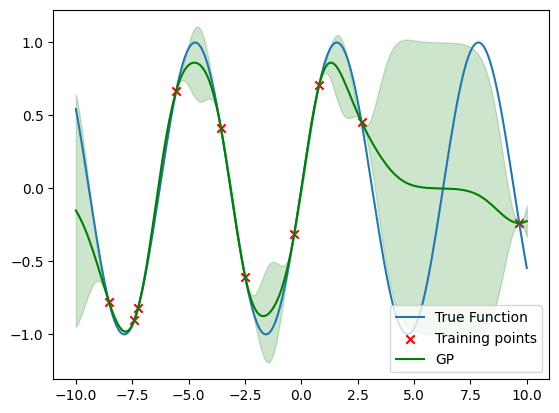

In [8]:
plt.plot(x_plot, y_plot, label="True Function")
plt.scatter(x_points, y_points, c="r",marker="x", label="Training points")
plt.plot(x_plot, mean1, c="g", label="GP")
plt.fill_between(x_plot, mean1-var1, mean1+var1, color="g", alpha=0.2)
plt.legend()